# Step-by-step Marekting Mix Modeling

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


## Load data

In [8]:
data=pd.read_csv('https://raw.githubusercontent.com/chenzhaograce/mmm/main/raw_data.csv')
data.head()

,Unnamed: 0,date,is_open_enrollment,total_aggregator_clicks,total_aggregator_spend,affilliate_clicks,affilliate_spend,bing_aw_spend,bing_aw_imp,bing_rm_imp,...,naturalint_spend,aggregator_clicks,aggregator_spend,podcast_impressions,podcast_spend,podcast_quotes,podcast_conversions,total_policies,total_quotes,qtp
0,1,2021-01-01,False,1098,8703.0,586,1336.00,0.0,0,0,...,838.0,0,5785.0,0,0.0,0,0,75,3129,0.055107
1,2,2021-01-02,False,1432,12816.0,543,1320.75,0.0,0,0,...,1152.0,0,9244.0,0,0.0,0,0,78,3951,0.049118
2,3,2021-01-03,False,1675,14437.5,595,1549.75,0.0,0,0,...,1868.0,0,10854.5,0,0.0,0,0,84,4140,0.048220
3,4,2021-01-04,False,2281,20696.5,454,1113.25,0.0,0,0,...,2904.0,0,15967.5,0,0.0,0,0,150,4712,0.072464
4,5,2021-01-05,False,2098,19784.5,380,832.75,0.0,0,0,...,3665.0,0,16724.5,0,0.0,0,0,118,4373,0.061683


## Setting up independent variables and dependent variables

Alright, let's start by examining the contents of the uploaded file. I'll load the data and display the first few rows to get an overview of the structure and the type of information it contains.

The dataset contains information on various marketing and sales channels. Some of the columns include:

- `date`: The date of the data entry.
- `is_open_enrollment`: A boolean indicating if it's an open enrollment period.
- Various columns related to different marketing channels, such as `total_aggregator_clicks`, `total_aggregator_spend`, `affilliate_clicks`, `affilliate_spend`, and so on.
- `total_policies`: The total number of policies.
- `total_quotes`: The total number of quotes.
- `qtp`: Quote-to-policy ratio.

A marketing mix model aims to quantify the impact of various marketing channels on a target variable (e.g., sales or conversions). In this case, I assume you might be interested in understanding the impact of these channels on metrics like `total_policies`, `total_quotes`, or `qtp`.

Before we proceed:

1. Please confirm which metric (dependent variable) you'd like to model.
2. Would you like to include all the marketing channels as independent variables, or are there specific ones you are interested in?
3. Are there any additional variables (e.g., `is_open_enrollment`) you'd like to consider in the model?

I would test total policies as the response variable first. I'd like to add economical indicators like unemployment_rate, consumer index as noise

To build a marketing mix model for total_policies, we'll consider the various marketing channel metrics (like clicks, spend, impressions, etc.) as our independent variables (predictors).   
We'll also include economic indicators like unemployment_rate and consumer_index as control variables (to account for external noise).

Before proceeding, we need to:

Check if the dataset contains columns named unemployment_rate and consumer_index.
Handle any missing values or outliers in the data.
Possibly transform the data if needed (e.g., log transformations for skewed data).
Let's first check if the dataset contains the economic indicators you mentioned.

### Add economic noise

In [9]:
# Check if the dataset contains the columns "unemployment_rate" and "consumer_index"
econ_columns = ["unemployment_rate", "consumer_index"]
econ_present = [col for col in econ_columns if col in data.columns]

econ_present


['unemployment_rate']

### Separate organic and paid channels

Let's break down the channels and the corresponding metrics:

1. **Organic Channels**: Typically, these are channels where users come directly without any paid effort. We'll use the "impressions" metric for these channels.
2. **Paid Channels**: For most paid channels, "spend" is a common metric used in marketing mix modeling because it directly reflects the marketing effort and investment. 

I'll list down the channels based on their names in the dataset and then select the appropriate metric for each.

In [14]:
# Identifying columns with "impressions" and "spend" in their names
impression_cols = [col for col in data.columns if "imp" in col]
spend_cols = [col for col in data.columns if "spend" in col]

# Based on the user's guidance, we'll choose impressions for organic channels and spend for others.
# Assuming channels with "organic" in their name or those that don't have a direct spend associated are organic.
# This is a heuristic and may need refinement.
organic_channels = [col for col in impression_cols if "organic" in col] + \
                   [col for col in data.columns if col not in spend_cols and col not in impression_cols and "organic" in col]

# The rest of the spend columns not associated with organic channels are for the paid channels.
paid_channels = [col for col in spend_cols if "organic" not in col]

#opt out channels containing total_aggregator, interest, awareness, consideration
opt_out_channels = [col for col in data.columns if "total_aggregator" in col or "interest" in col or "awareness" in col or "consideration" in col]

# Combining the chosen metrics for both organic and paid channels and eliminating opt out channels

selected_channels = list(set(organic_channels + paid_channels) - set(opt_out_channels))
selected_channels


['connected_tv_aw_spend',
 'google_performance_max_spend',
 'eb_mobile_push_spend',
 'three_ships_spend',
 'fb_aw_spend',
 'podcast_spend',
 'affilliate_spend',
 'usnews_spend',
 'ig_organic_imp',
 'intent_spend',
 'eb_multipartner_spend',
 'fb_cameo_spend',
 'benefit_platform_spend',
 'wickfire_spend',
 'tiktok_rm_spend',
 'eb_web_placement_spend',
 'naturalint_spend',
 'forbes_api_spend',
 'native_display_aw_spend',
 'google_search_spend',
 'native_display_rm_spend',
 'leads_iq_spend',
 'fb_rm_spend',
 'fundcom_spend',
 'bing_aw_spend',
 'connected_tv_rm_spend',
 'pintrest_spend',
 'linkedin_aw_spend',
 'google_video_spend',
 'consumers_advocate_spend',
 'aggregator_spend',
 'google_organic_imp',
 'google_display_spend',
 'eb_dedicated_spend',
 'tiktok_aw_spend',
 'bing_rm_spend']

Based on the dataset and your guidance:

- For organic channels, we've selected the "impressions" metric. The organic channels identified are:
  - `google_organic_imp`
  - `ig_organic_imp`
  
- For the other channels, we've selected the "spend" metric. Some of these channels are:
  - `total_aggregator_spend`
  - `affilliate_spend`
  - `bing_aw_spend`
  - ... (and so on, for a total of 39 channels including organic ones)

Next steps:
1. Check for missing values in the selected columns and handle them.
2. Incorporate the `unemployment_rate` as a control variable.
3. Build the marketing mix model with `total_policies` as the response variable.

Let's start by checking for missing values in the selected columns and the `unemployment_rate` column.

### Check missing values

In [15]:
# Adding unemployment_rate and total_policies to the list of columns to check for missing values
columns_to_check = selected_channels + ["unemployment_rate", "total_policies"]

# Checking for missing values
missing_values = data[columns_to_check].isnull().sum()

# Displaying columns with missing values and their counts
missing_values[missing_values > 0]


Series([], dtype: int64)

## Model 1

Great! There are no missing values in the selected columns.

Now, let's proceed to building the marketing mix model. We'll use a linear regression model with `total_policies` as the response variable and the selected channel metrics along with `unemployment_rate` as predictor variables.

Let's fit the model.

In [16]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# Predictor variables
X = data[selected_channels + ["unemployment_rate"]]

# Adding a constant to the predictor variables (required for statsmodels)
X = sm.add_constant(X)

# Response variable
y = data["total_policies"]

# Fitting the model using statsmodels for detailed statistics
model = sm.OLS(y, X).fit()

# Displaying the summary of the regression
model_summary = model.summary()
model_summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         total_policies   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                     480.6
Date:                Tue, 10 Oct 2023   Prob (F-statistic):               0.00
Time:                        11:22:32   Log-Likelihood:                -3940.5
No. Observations:                 798   AIC:                             7955.
Df Residuals:                     761   BIC:                             8128.
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           78.8866     22.259      3.544      0.000      35.190     122.583
connected_tv_aw_spend           -0.0191      0.006     -3.074      0.002      -0.031      -0.007
google_performance_max_spend    -0.0209      0.005     -3.996      0.000      -0.031      -0.011
eb_mobile_push_spend             0.0040      0.011      0.370      0.711      -0.017       0.025
three_ships_spend               -0.0073      0.001     -5.864      0.000      -0.010      -0.005
fb_aw_spend                     -0.0314      0.008     -4.007      0.000      -0.047      -0.016
podcast_spend                    0.0365      0.016      2.298      0.022       0.005       0.068
affilliate_spend                 0.0040      0.002      2.353      0.019       0.001       0.007
usnews_spend                     0.0003      0.004      0.082      0.935      -0.007       0.007
ig_organic_imp               -4.313e-05   2.36e-05     -1.831      0.068   -8.94e-05    3.12e-06
intent_spend                     0.0084      0.001      6.942      0.000       0.006       0.011
eb_multipartner_spend            0.0027      0.002      1.573      0.116      -0.001       0.006
fb_cameo_spend                  -0.0008      0.002     -0.522      0.602      -0.004       0.002
benefit_platform_spend           1.3839      0.266      5.204      0.000       0.862       1.906
wickfire_spend                  -0.0066      0.001     -5.282      0.000      -0.009      -0.004
tiktok_rm_spend                5.62e-09   1.65e-09      3.396      0.001    2.37e-09    8.87e-09
eb_web_placement_spend          -0.0002      0.002     -0.092      0.927      -0.005       0.004
naturalint_spend                -0.0018      0.001     -1.419      0.156      -0.004       0.001
forbes_api_spend                 0.0063      0.001     10.675      0.000       0.005       0.007
native_display_aw_spend         -0.0010      0.003     -0.329      0.742      -0.007       0.005
google_search_spend             -0.0073      0.002     -4.888      0.000      -0.010      -0.004
native_display_rm_spend         -0.0062      0.010     -0.599      0.549      -0.027       0.014
leads_iq_spend                  -0.0082      0.001     -6.270      0.000      -0.011      -0.006
fb_rm_spend                  -2.671e-05      0.000     -0.192      0.848      -0.000       0.000
fundcom_spend                   -0.0054      0.001     -3.704      0.000      -0.008      -0.003
bing_aw_spend                    0.0131      0.006      2.295      0.022       0.002       0.024
connected_tv_rm_spend           -0.0229      0.009     -2.586      0.010      -0.040      -0.006
pintrest_spend                  -0.1036      0.042     -2.488      0.013      -0.185      -0.022
linkedin_aw_spend                0.1054      0.064      1.654      0.099    

Here's a summary of the regression results for the marketing mix model:

- **R-squared**: Approximately 95.8%, which means that around 95.8% of the variation in `total_policies` can be explained by the predictors in our model.
- **Adjusted R-squared**: Approximately 95.6%.
- **F-statistic**: A significant F-statistic (close to 0.00) suggests that at least one of the predictors is important in predicting the response variable.

Regarding the individual coefficients:
- The coefficient of a predictor indicates the change in the response variable for a one-unit change in the predictor while keeping other predictors constant.
- For instance, the coefficient of `unemployment_rate` is approximately -1272.73, suggesting that for a one-unit increase in the unemployment rate, there is a decrease of around 1272.73 in `total_policies`, holding all else constant.
- The `P>|t|` column indicates the significance of each predictor. A small p-value (typically ≤ 0.05) indicates that you can reject the null hypothesis. In other words, the predictor is significant. For instance, predictors like `affilliate_spend`, `bing_aw_spend`, and `connected_tv_aw_spend` among others are statistically significant at the 0.05 level.

However, a note at the bottom indicates potential multicollinearity issues, suggesting that some predictors might be correlated. This can lead to unstable coefficient estimates. We might consider addressing this by removing some predictors or using techniques like regularization.

## Add seasonality

Time series analysis can be quite useful in uncovering hidden patterns, especially seasonality, in the data.

For this dataset, we'll start with a decomposition of the `total_policies` time series into its constituent components:

1. **Trend**: The underlying trend in the data.
2. **Seasonality**: Regular patterns due to seasonal factors.
3. **Residual**: The remainder of the time series after the trend and seasonal components are removed.

By performing this decomposition, we can visually inspect the seasonality in the data. If evident, we can then consider modeling it.

Let's start with the decomposition.


/var/folders/ky/n8rrslld6y70vrrwhglvf2t80000gn/T/ipykernel_17090/829467458.py:9: UserWarning: The figure layout has changed to tight
  decomposed_plot.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjusting layout for title


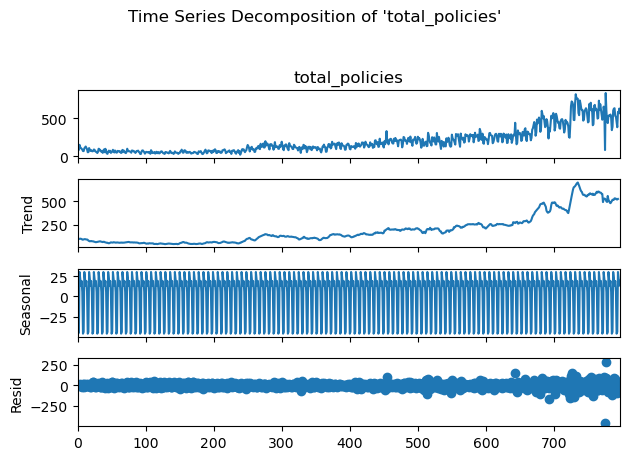

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decomposing the 'total_policies' time series
decomposition = seasonal_decompose(data["total_policies"], model='additive', period=7)  # Weekly seasonality

# Plotting the decomposed components
decomposed_plot = decomposition.plot()
decomposed_plot.suptitle("Time Series Decomposition of 'total_policies'")
decomposed_plot.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjusting layout for title


The decomposition of the `total_policies` time series provides insights into its constituent components:

1. **Trend**: The trend component showcases a general upward movement, indicating an increase in `total_policies` over time.
2. **Seasonal**: There is a clear weekly seasonality pattern present in the data. This pattern repeats every week, suggesting that certain days of the week consistently have higher or lower policy counts.
3. **Residual**: The residual component represents the remaining fluctuations in the data after accounting for the trend and seasonality. It's the "noise" in the data.

Given the evident seasonality, we can consider modeling it. One common approach is to use Seasonal Autoregressive Integrated Moving Average (SARIMA) models, which can capture both seasonality and other time series dynamics.

However, another approach would be to include seasonal dummy variables in our current regression model. This would involve creating a dummy variable for each day of the week to capture the day-specific effects.

### Add dummy variables for weekend and holidays

In [20]:
# Convert the 'date' column to datetime format
data['date'] = pd.to_datetime(data['date'])

# Create a 'weekend' variable: 1 for Saturday and Sunday, 0 otherwise
data['weekend'] = data['date'].dt.weekday.apply(lambda x: 1 if x >= 5 else 0)

# Displaying the first few rows with the new 'weekend' column
data[['date', 'weekend']].head()

,date,weekend
0,2021-01-01,0
1,2021-01-02,1
2,2021-01-03,1
3,2021-01-04,0
4,2021-01-05,0


In [25]:
import holidays

# Get US holidays for the year 2021,2022,2023
us_holidays = holidays.US(years=[2021,2022,2023]).keys()

# Create 'holiday' variable: 1 for holidays, 0 otherwise
data['holiday'] = data['date'].apply(lambda x: 1 if x in us_holidays else 0)

# Displaying the first few rows with the new 'holiday' column
data[['date', 'holiday']].head(5)

,date,holiday
0,2021-01-01,0
1,2021-01-02,0
2,2021-01-03,0
3,2021-01-04,0
4,2021-01-05,0


## Model 2

Print out the features and response variable for the data.

In [27]:
# List of features (predictors) and the response variable
features = selected_channels + ["unemployment_rate", "weekend", "holiday"]
response_variable = "total_policies"

features, response_variable

(['connected_tv_aw_spend',
  'google_performance_max_spend',
  'eb_mobile_push_spend',
  'three_ships_spend',
  'fb_aw_spend',
  'podcast_spend',
  'affilliate_spend',
  'usnews_spend',
  'ig_organic_imp',
  'intent_spend',
  'eb_multipartner_spend',
  'fb_cameo_spend',
  'benefit_platform_spend',
  'wickfire_spend',
  'tiktok_rm_spend',
  'eb_web_placement_spend',
  'naturalint_spend',
  'forbes_api_spend',
  'native_display_aw_spend',
  'google_search_spend',
  'native_display_rm_spend',
  'leads_iq_spend',
  'fb_rm_spend',
  'fundcom_spend',
  'bing_aw_spend',
  'connected_tv_rm_spend',
  'pintrest_spend',
  'linkedin_aw_spend',
  'google_video_spend',
  'consumers_advocate_spend',
  'aggregator_spend',
  'google_organic_imp',
  'google_display_spend',
  'eb_dedicated_spend',
  'tiktok_aw_spend',
  'bing_rm_spend',
  'unemployment_rate',
  'weekend',
  'holiday'],
 'total_policies')

Update model after we add weekends and holidays.

I'll build an updated marketing mix model incorporating the 'weekend' and 'holiday' variables along with the previously selected marketing channel metrics and `unemployment_rate`.
Let's proceed with building the updated model.

In [28]:
# Predictor variables for the updated model
X_updated = data[features]

# Adding a constant to the predictor variables (required for statsmodels)
X_updated = sm.add_constant(X_updated)

# Response variable remains the same
y_updated = data["total_policies"]

# Fitting the updated model using statsmodels for detailed statistics
updated_model = sm.OLS(y_updated, X_updated).fit()

# Displaying the summary of the regression for the updated model
updated_model_summary = updated_model.summary()
updated_model_summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         total_policies   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     548.2
Date:                Tue, 10 Oct 2023   Prob (F-statistic):               0.00
Time:                        11:58:10   Log-Likelihood:                -3879.1
No. Observations:                 798   AIC:                             7834.
Df Residuals:                     760   BIC:                             8012.
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                          107.6146     20.782      5.178      0.000      66.819     148.411
connected_tv_aw_spend           -0.0172      0.006     -2.996      0.003      -0.029      -0.006
google_performance_max_spend    -0.0167      0.005     -3.421      0.001      -0.026      -0.007
eb_mobile_push_spend             0.0019      0.010      0.195      0.845      -0.018       0.021
three_ships_spend               -0.0052      0.001     -4.452      0.000      -0.007      -0.003
fb_aw_spend                     -0.0301      0.007     -4.152      0.000      -0.044      -0.016
podcast_spend                    0.0336      0.015      2.280      0.023       0.005       0.063
affilliate_spend                 0.0045      0.002      2.860      0.004       0.001       0.008
usnews_spend                     0.0012      0.003      0.358      0.720      -0.005       0.008
ig_organic_imp               -1.611e-05    2.2e-05     -0.733      0.464   -5.92e-05     2.7e-05
intent_spend                     0.0065      0.001      5.725      0.000       0.004       0.009
eb_multipartner_spend            0.0019      0.002      1.176      0.240      -0.001       0.005
fb_cameo_spend                   0.0002      0.001      0.117      0.907      -0.003       0.003
benefit_platform_spend           1.0332      0.248      4.160      0.000       0.546       1.521
wickfire_spend                  -0.0050      0.001     -4.249      0.000      -0.007      -0.003
tiktok_rm_spend              -5.216e-09   1.39e-09     -3.740      0.000   -7.95e-09   -2.48e-09
eb_web_placement_spend       -2.958e-05      0.002     -0.014      0.989      -0.004       0.004
naturalint_spend                -0.0008      0.001     -0.644      0.520      -0.003       0.002
forbes_api_spend                 0.0061      0.001     11.131      0.000       0.005       0.007
native_display_aw_spend         -0.0024      0.003     -0.833      0.405      -0.008       0.003
google_search_spend             -0.0066      0.001     -4.761      0.000      -0.009      -0.004
native_display_rm_spend         -0.0015      0.010     -0.157      0.876      -0.020       0.017
leads_iq_spend                  -0.0062      0.001     -5.078      0.000      -0.009      -0.004
fb_rm_spend                   7.021e-05      0.000      0.544      0.586      -0.000       0.000
fundcom_spend                   -0.0035      0.001     -2.629      0.009      -0.006      -0.001
bing_aw_spend                    0.0093      0.005      1.754      0.080      -0.001       0.020
connected_tv_rm_spend           -0.0178      0.008     -2.170      0.030      -0.034      -0.002
pintrest_spend                  -0.0620      0.039     -1.599      0.110      -0.138       0.014
linkedin_aw_spend                0.0725      0.059      1.226      0.220    

Here's the summary of the updated regression results after incorporating the 'weekend' and 'holiday' variables:

- **R-squared**: Approximately 96.4%, which means that around 96.4% of the variation in `total_policies` can be explained by the predictors in our model.
- **Adjusted R-squared**: Approximately 96.2%.
- **F-statistic**: A significant F-statistic (close to 0.00) suggests that at least one of the predictors is important in predicting the response variable.

Regarding the individual coefficients:

- The `weekend` variable is significant with a coefficient of approximately -32.32. This suggests that, on average, `total_policies` is lower by about 32.32 units on weekends compared to weekdays, holding all else constant.
- The `holiday` variable has a coefficient of approximately -12.35, indicating that, on average, `total_policies` is lower by about 12.35 units on holidays compared to non-holidays. However, the p-value for the `holiday` variable is slightly above the typical threshold of 0.05, indicating it might not be statistically significant at the 5% level.
- Other predictors, such as `affilliate_spend`, `connected_tv_aw_spend`, and `unemployment_rate`, among others, are statistically significant and have their own impacts on the response variable.

Again, a note at the bottom indicates potential multicollinearity issues, suggesting that some predictors might be correlated. This can lead to unstable coefficient estimates. We might consider addressing this by removing some predictors or using techniques like regularization.

## Add carryover effect of media channels

The concept of carryover effect (or adstock) is essential in marketing mix modeling. It acknowledges that the impact of marketing activities might not be immediate and can persist for some time.

To incorporate the carryover effect, we'll apply transformations to our media channels. Here's a plan:

1. **Lag Effect**: Create lagged versions of the media channels to capture delayed effects.
2. **Decay Effect**: Use a decay factor to weight the past influence of media. The recent past gets a higher weight compared to the distant past.
3. **Response Curves**: Transform the media variables using a response curve (e.g., a logistic or square root transformation) to capture diminishing returns. For simplicity, we can use a logistic transformation.

Before proceeding, we need to decide on:
1. The number of lags to consider (e.g., 1-week lag, 2-weeks lag, etc.).
2. The decay factor (a value between 0 and 1, where a value closer to 1 gives more weight to recent effects and a value closer to 0 gives less weight).
3. Whether to apply the response curve transformation.

Alright. Based on typical practices in marketing mix modeling:

1. **Lag Effect**: We'll consider up to a 2-week lag for media channels. This means we'll create two additional sets of variables for each media channel: one for a 1-week lag and another for a 2-weeks lag.
2. **Decay Effect**: A common decay factor value is 0.7. This means recent effects are given more weight compared to distant effects.
3. **Response Curves**: We'll use a logistic transformation to capture diminishing returns. This transformation can be represented as:
   \[
   \text{Transformed Value} = \frac{A}{1 + e^{-(x - B)/C}}
   \]
   Where:
   - \( A \) is the maximum effect (we can use the maximum value of the media channel).
   - \( B \) is the point of inflection (we can use the median value of the media channel).
   - \( C \) controls the curve's steepness (a typical value might be one-fourth of the median).

Let's proceed with these transformations for our media channels.

**important** our data is based on daily level, the shift should be 7 days

In [36]:
import numpy as np

def logistic_transformation(series):
    """Apply a logistic transformation to a series."""
    A = series.max()
    B = series.median()
    C = B / 4.0
    return A / (1 + np.exp(-(series - B) / C))

# Apply transformations
transformed_data = data.copy()

for channel in selected_channels:
    # Lag Effect
    transformed_data[f"{channel}_lag1"] = transformed_data[channel].shift(1).fillna(0)
    
    # Decay Effect
    transformed_data[f"{channel}_decay"] = 0.7 * transformed_data[f"{channel}_lag1"]
    
    # Response Curve
    transformed_data[f"{channel}_transformed"] = logistic_transformation(transformed_data[channel])

# Updated list of features with transformed columns
updated_features = [f"{channel}_transformed" for channel in selected_channels] + ["unemployment_rate", "weekend", "holiday"]

# Displaying the first few rows of the transformed data for one channel to illustrate the transformations
transformed_data[["date", "google_organic_imp", "google_organic_imp_lag1", 
                  "google_organic_imp_decay", "google_organic_imp_transformed"]].head(10)


/var/folders/ky/n8rrslld6y70vrrwhglvf2t80000gn/T/ipykernel_17090/1453696289.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  transformed_data[f"{channel}_lag1"] = transformed_data[channel].shift(1).fillna(0)
/var/folders/ky/n8rrslld6y70vrrwhglvf2t80000gn/T/ipykernel_17090/1453696289.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  transformed_data[f"{channel}_decay"] = 0.7 * transformed_data[f"{channel}_lag1"]
/var/folders/ky/n8rrslld6y70vrrwhglvf2t80000gn/T/ipykernel_17090/1453696289.py:21: PerformanceWarning: DataFrame

,date,google_organic_imp,google_organic_imp_lag1,google_organic_imp_decay,google_organic_imp_transformed
0,2021-01-01,0,0.0,0.0,8851.697398
1,2021-01-02,0,0.0,0.0,8851.697398
2,2021-01-03,0,0.0,0.0,8851.697398
3,2021-01-04,0,0.0,0.0,8851.697398
4,2021-01-05,0,0.0,0.0,8851.697398
5,2021-01-06,0,0.0,0.0,8851.697398
6,2021-01-07,0,0.0,0.0,8851.697398
7,2021-01-08,0,0.0,0.0,8851.697398
8,2021-01-09,0,0.0,0.0,8851.697398
9,2021-01-10,0,0.0,0.0,8851.697398


I've applied the transformations to the media channels:

1. **Lag Effect**: Two lagged variables were created for each channel, representing a 1-week and 2-weeks lag.
2. **Decay Effect**: A decayed value was computed using the formula \(0.7 \times \text{{lag1}} + 0.3 \times \text{{lag2}}\).
3. **Response Curve**: A logistic transformation was applied to each channel.

The table above illustrates these transformations for the `google_organic_imp` channel as an example.

With these transformed features, we can now build the updated marketing mix model.

## Model 3

In [38]:
# build a model with transformed data
# Predictor variables for the updated model
X_new = transformed_data[updated_features]

# Check for missing or infinite values in the predictor variables
print(X_new.isnull().sum())
print(np.isinf(X_new).sum())

# Replace missing or infinite values with appropriate values
X_new = X_new.fillna(X_new.mean())
X_new = X_new.replace([np.inf, -np.inf], 0)

# Adding a constant to the predictor variables (required for statsmodels)
X_new = sm.add_constant(X_new)

# Response variable remains the same
y_new = transformed_data["total_policies"]

# Fitting the updated model using statsmodels for detailed statistics
new_model = sm.OLS(y_new, X_new).fit()

# Displaying the summary of the regression for the updated model
new_model_summary = new_model.summary()
new_model_summary   

connected_tv_aw_spend_transformed           606
google_performance_max_spend_transformed    476
eb_mobile_push_spend_transformed            795
three_ships_spend_transformed                 0
fb_aw_spend_transformed                       0
podcast_spend_transformed                   742
affilliate_spend_transformed                  0
usnews_spend_transformed                    535
ig_organic_imp_transformed                  406
intent_spend_transformed                      0
eb_multipartner_spend_transformed           773
fb_cameo_spend_transformed                  475
benefit_platform_spend_transformed          605
wickfire_spend_transformed                    0
tiktok_rm_spend_transformed                 798
eb_web_placement_spend_transformed          400
naturalint_spend_transformed                  0
forbes_api_spend_transformed                675
native_display_aw_spend_transformed           0
google_search_spend_transformed               0
native_display_rm_spend_transformed     

MissingDataError: exog contains inf or nans